# Sentimental Analysis of Rotten Tomatoes Reviews.

<hr style="border: 2px solid red; border-radius: 50%;">

## Importing Packages.

In [1]:
!pip install tqdm nltk lightgbm

### ⚠️ If you encounter NLTK Download errors, then follow the steps below to fix it.
https://developers.cloudflare.com/1.1.1.1/setup/windows/

In [128]:
import warnings
import string
import re
import socket
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import typing
import lightgbm as lgbm

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from collections.abc import Callable

nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download("wordnet")

[nltk_data] Downloading package punkt to C:\Users\DELL
[nltk_data]     5590\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\DELL
[nltk_data]     5590\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\DELL
[nltk_data]     5590\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

<hr style="border: 2px solid red; border-radius: 50%;">

## Loading the Data.

In [4]:
reviews_df = pd.read_csv('reviewsdata.csv')

<hr style="border: 2px solid red; border-radius: 50%;">

### Checking Proportion of the type of Reviews.

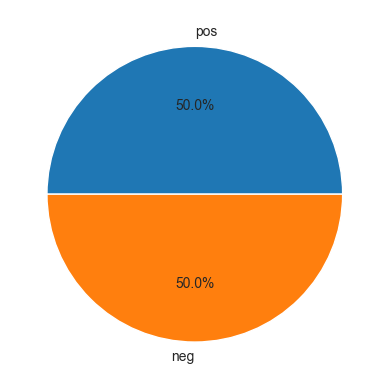

In [5]:
plt.pie(reviews_df['Label'].value_counts(), labels=reviews_df['Label'].unique().tolist(), autopct='%1.1f%%')
plt.show()

<hr style="border: 2px solid red; border-radius: 50%;">

## 1. Cleaning the Reviews.

As long as we consider the global internet as the source of our Reviews, probably we have to deal with some HTML tags, break lines, special characters and other content that could be part of the dataset.


#### 1.a. Helper function for Finding Regex Patterns.

In [6]:
def find_patterns(re_pattern: str, text_list: typing.List[str]):
    """
    Args:
    ----------
    re_pattern [type: str]: Regular expression pattern to be used on search.
    text_list [type: list]: List with text strings.

    Returns:
    ---------
    positions_dict: python dictionary with key-value pairs as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ..., (start_pattern_n, end_pattern_n)]
    """

    # Compiling the ReGex passed as arg.
    pattern = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = pattern.finditer(c)
        for match in iterator:
            match_list.append(match.span())

        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            continue
        positions_dict[control_key] = match_list
        i += 1

    return positions_dict

In [7]:
def print_step_result(text_list_before: typing.List[str], text_list_after: typing.List[str], idx_list: typing.List[int]):
    """
    Args:
    -------

    text_list_before [type: List[str]]: list object with text content before transformation.
    text_list_after [type: List[str]]: list object with text content after transformation.
    idx_list [type: List[str]]: list object with indexes to be printed.
    """

    # iterating over string examples.
    i = 1
    for idx in idx_list:
        print(f"--- Text {i} --- \n")
        print(f"Before: \n{text_list_before[idx]}\n")
        print(f"After: \n{text_list_after[idx]}\n")
        i += 1

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.1: Breakline and Carriage Return

In [8]:
def re_breakline(text_list: typing.List[str]) -> typing.List[str]:
    """
    Args:
    ---------
    text_list [type: List[str]]: List object with text content to be cleaned.

    Returns:
    ---------
    [type: List[str]]: Transformed / Cleaned text context.
    """

    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [9]:
# creating list of reviews.
reviews = reviews_df['Review'].values.tolist()

# Applying the ReGex.
reviews_breakline = re_breakline(reviews)
reviews_df['Review'] = reviews_breakline

# verifying results
print_step_result(reviews, reviews_breakline, idx_list=[6])

--- Text 1 --- 

Before: 
offers that rare combination of entertainment and education .

After: 
offers that rare combination of entertainment and education .



<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.2: Threads and Hyperlinks

Another pattern that must be treated is sites and hyperlinks.

In [10]:
def re_hyperlinks(text_list: typing.List[str]) -> typing.List[str]:
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]

    Returns:
    ----------
    [type: List[str]]: Transformed / Cleaned text context.
    """

    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [11]:
# Applying ReGex.
reviews_hyperlinks = re_hyperlinks(reviews_breakline)
reviews_df['Review'] = reviews_hyperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hyperlinks, idx_list=[15, 4])

--- Text 1 --- 

Before: 
an utterly compelling 'who wrote it' in which the reputation of the most famous author who ever lived comes into question .

After: 
an utterly compelling 'who wrote it' in which the reputation of the most famous author who ever lived comes into question .

--- Text 2 --- 

Before: 
emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .

After: 
emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .



<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.3: Negations.

The problem statement is that when we remove the stopwords, probabily we would loose the meaning of some phrases about removing the negation words like [not, never], for example. So, because of this, maybe is a good idea to replace some negation words with some common words indicating a negation meaning.

In [12]:
negations = r"\b(?:never|no|nothing|nowhere|noone|none|not|havent|hasn't|hadn't|can't|couldn't|shouldn't|won't|wouldn't|don't|doesn't|didn't|isn't|aren't|ain't)\b"
negation_pattern = re.compile(f"({negations})\s+([a-zA-Z]+)")

def re_negation(text_list: typing.List[str], pattern) -> typing.List[str]:
    """
    Args:
    -------
    text_series [text: List[str]]: List object with text content to be transformed.

    Returns:
    ----------
    [type: List[str]]: Transformed / Cleaned text context.
    """
    return [pattern.sub(lambda match: f"{match.group(1)}_{match.group(2)}", review) for review in text_list]

In [13]:
# Applying ReGex.
reviews_negation = re_negation(reviews_breakline, negation_pattern)
reviews_df['Review'] = reviews_negation

# Verifying results
print_step_result(reviews_breakline, reviews_negation, idx_list=[4, 8])

--- Text 1 --- 

Before: 
emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .

After: 
emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't_feel like one .

--- Text 2 --- 

Before: 
steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .

After: 
steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .



<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.4: Special Characters.

The search for special characters is really special one because we see a lot of this pattern on online comments.

In [14]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]

    Returns:
    ----------
    [type: List[str]]: Transformed / Cleaned text context.
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [15]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
reviews_df['Review'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[4, 8])

--- Text 1 --- 

Before: 
emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't_feel like one .

After: 
emerges as something rare   an issue movie that s so honest and keenly observed that it doesn t_feel like one  

--- Text 2 --- 

Before: 
steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .

After: 
steers turns in a snappy screenplay that curls at the edges   it s so clever you want to hate it   but he somehow pulls it off  



<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.5: Additional Whitespaces.

After all the steps we have taken over here, it's important to clean our text eliminating unnecessary whitespaces.

In [16]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [17]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
reviews_df['Review'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[4, 8])

--- Text 1 --- 

Before: 
emerges as something rare   an issue movie that s so honest and keenly observed that it doesn t_feel like one  

After: 
emerges as something rare an issue movie that s so honest and keenly observed that it doesn t_feel like one

--- Text 2 --- 

Before: 
steers turns in a snappy screenplay that curls at the edges   it s so clever you want to hate it   but he somehow pulls it off  

After: 
steers turns in a snappy screenplay that curls at the edges it s so clever you want to hate it but he somehow pulls it off



<hr style="border: 1px solid yellow; border-radius: 50%;">

### 1.6: Stopwords.

Removing the english stopwords.

In [18]:
def remove_stopwords(text_list: typing.List[str]) -> typing.List[str]:
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    return [" ".join([word for word in review.split() if word not in stopwords.words('english')]) for review in text_list]

In [19]:
reviews_stopwords = remove_stopwords(reviews_whitespaces)
reviews_df['Review'] = reviews_stopwords

# Verifying results
print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[4, 8])

--- Text 1 --- 

Before: 
emerges as something rare an issue movie that s so honest and keenly observed that it doesn t_feel like one

After: 
emerges something rare issue movie honest keenly observed t_feel like one

--- Text 2 --- 

Before: 
steers turns in a snappy screenplay that curls at the edges it s so clever you want to hate it but he somehow pulls it off

After: 
steers turns snappy screenplay curls edges clever want hate somehow pulls



<hr style="border: 2px solid red; border-radius: 50%;">

## 2. Exploring the dataset.

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 2.1: How big is the data? What is the shape of the data?

In [20]:
print(f"The dataset consists of {reviews_df.shape[0]} rows, and {reviews_df.shape[1]} columns")

The dataset consists of 10662 rows, and 2 columns


<hr style="border: 1px solid yellow; border-radius: 50%;">

### 2.2: How does the data look like?

In [21]:
reviews_df.sample(5)

,Review,Label
3258,surprisingly decent particularly tenth install...,pos
7540,last time saw theater full people constantly c...,neg
4777,fascinating examination joyous turbulent self ...,pos
5270,spielberg realization near future america mast...,pos
4924,comedy makes social commentary palatable,pos


<hr style="border: 1px solid yellow; border-radius: 50%;">

### 2.3: What is the data type of columns?

In [22]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10662 non-null  object
 1   Label   10662 non-null  object
dtypes: object(2)
memory usage: 166.7+ KB


The data consists of string types.
Label is the categorical data.

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 2.4: Are there any missing values?

In [23]:
(reviews_df.isnull().sum() / reviews_df.shape[0]) * 100

Review    0.0
Label     0.0
dtype: float64

There are no missing values in the dataset

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 2.5: Counts and Length of the Reviews
We will be checking the:
1. Character Count.
2. Word Count.
3. Mean Word Length.
4. Mean Sentence Length.

##### Copy of Original dataset for Exploration.

In [24]:
eda_df = reviews_df.copy()

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 2.5.1: Length of reviews.

In [25]:
length = len(eda_df.sample(1)['Review'].to_list()[0])
print(f"Length of a sample review: {length}")

Length of a sample review: 108


In [26]:
eda_df['Length'] = eda_df['Review'].str.len()

In [27]:
eda_df.sample(10)

,Review,Label,Length
3192,may sound like mere disease week tv movie song...,pos,126
3667,much lady duke quiet decisive moments members ...,pos,93
4736,bodice ripper intellectuals,pos,27
305,could say slow times could say characters act ...,pos,102
4114,movie best work us second helpings love romanc...,pos,154
9576,superior plotline t_quite enough drag along de...,neg,61
4130,red dragon worthy place alongside hannibal mov...,pos,95
33,way effectively teach kids dangers drugs think...,pos,87
8570,broomfield style journalism hardly journalism ...,neg,87
9850,wishy washy,neg,11


<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 2.5.2: Word Count: Number of words in a review.

In [28]:
word_count = eda_df['Review'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 19


In [29]:
def get_word_count(review: str) -> int:
    review_list = review.split()
    return len(review_list)

In [30]:
eda_df['Word_count'] = eda_df['Review'].apply(get_word_count)

In [31]:
eda_df.sample(10)

,Review,Label,Length,Word_count
7094,stealing harvard aspires comedic grand larceny...,neg,93,12
3330,charm revolution os rather way introduces new ...,pos,84,12
1408,not_since japanese filmmaker akira kurosawa ra...,pos,106,13
2218,angela gheorghiu famous prima donna floria tos...,pos,169,22
3004,bloody sunday lacks clarity makes great fiery ...,pos,53,8
7025,effort suspect not_to offend appearing either ...,neg,86,11
5889,tuxedo bad friend david cross would call hungr...,neg,64,11
6978,not_exactly bees knees,neg,22,3
2817,salma goes native never_been better colorful b...,pos,65,10
6393,nothing_more widget cranked assembly line see ...,neg,141,20


<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 2.5.3: Mean word length: Average Length of words in the review.

In [32]:
eda_df['mean_word_length'] = eda_df['Review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [33]:
eda_df.sample(10)

,Review,Label,Length,Word_count,mean_word_length
774,amazing incendiary movie dives straight rough ...,pos,66,8,7.375000
7153,overemphatic would wacky ultimately tedious se...,neg,53,7,6.714286
3407,unusual food thought cinema entertaining instr...,pos,52,6,7.833333
5394,characters never_more sketches leaves true emo...,neg,98,10,8.900000
5810,mechanical action comedy whose seeming purpose...,neg,100,13,6.769231
10123,precise nature matthew predicament finally com...,neg,91,12,6.666667
8148,apallingly absurd chemistry lack thereof newto...,neg,106,16,5.687500
4405,schmidt nicholson goofy heartfelt mesmerizing ...,pos,55,7,7.000000
6350,bond film goes beaten path not_necessarily better,neg,49,7,6.142857
8228,film two mismatched buddies crystal de niro sh...,neg,88,14,5.357143


<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 2.5.4: Mean sentence length: Average Length of sentences in the review.

In [34]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(eda_df['Review'][0])])

123.0

In [35]:
eda_df['mean_sent_length'] = eda_df['Review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

In [36]:
eda_df.sample(10)

,Review,Label,Length,Word_count,mean_word_length,mean_sent_length
5162,realistically terrifying movie puts another no...,pos,83,12,6.000000,83.0
10116,24 unders looking caddyshack adopt generationa...,neg,73,10,6.400000,73.0
2670,shows us slice life different yet instantly re...,pos,56,8,6.125000,56.0
9958,rather leaden dull,neg,18,3,5.333333,18.0
10449,upside unpleasantness given labor day weekend ...,neg,87,12,6.333333,87.0
4036,get image big papa spanning history rather sus...,pos,53,8,5.750000,53.0
1978,romantic comedy plotline straight ages cindere...,pos,110,15,6.400000,110.0
3763,film reminds vastly improved germanic version ...,pos,166,23,6.260870,166.0
8201,wish could say thank god friday truth matter glad,neg,49,9,4.555556,49.0
1104,makes even claustrophobic board quarters seem fun,pos,49,7,6.142857,49.0


<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 2.5.5: Visualizing the Data.

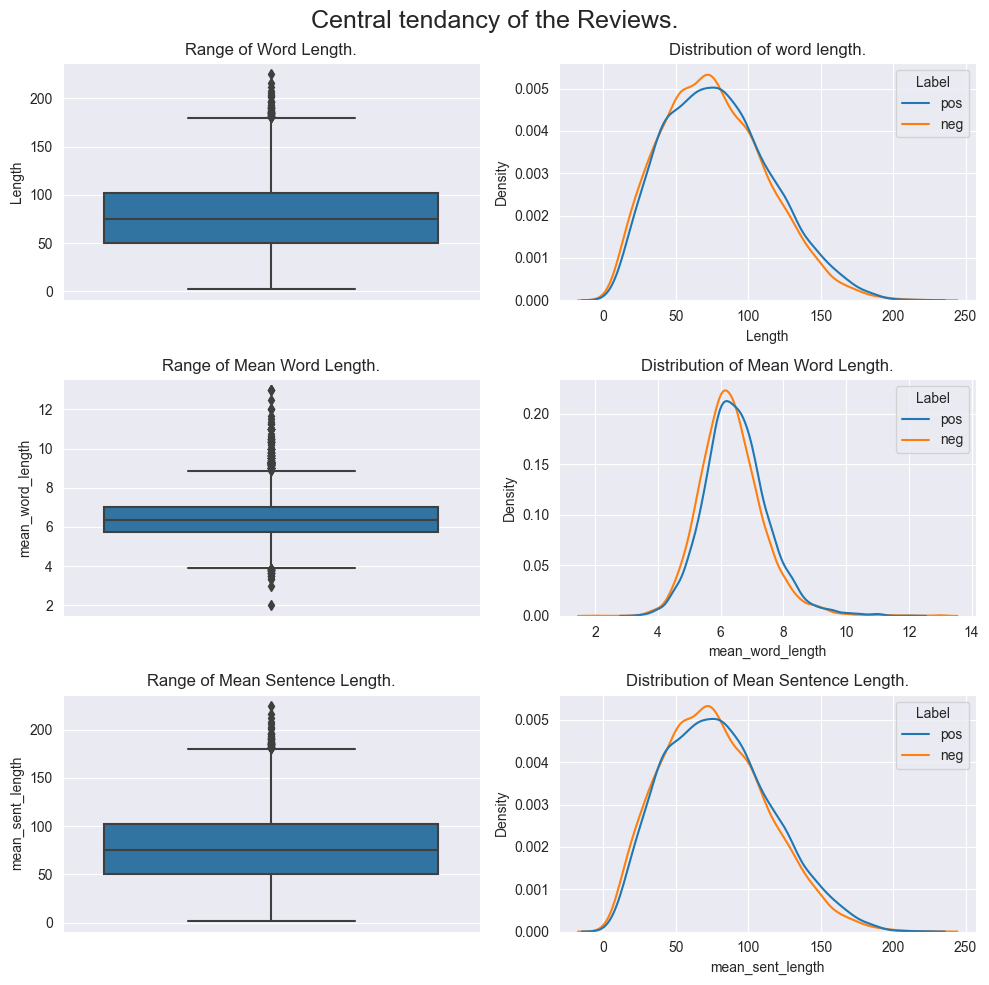

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10), layout='tight')
fig.suptitle("Central tendancy of the Reviews.", fontsize=18)

len_box_plot = sns.boxplot(y=eda_df['Length'], hue=eda_df['Label'], ax=ax[0][0])
ax[0][0].set_title("Range of Word Length.")


len_line_plot = sns.kdeplot(x=eda_df['Length'], hue=eda_df['Label'], ax=ax[0][1])
ax[0][1].set_title("Distribution of word length.")


mean_word_count_box_plot = sns.boxplot(y=eda_df['mean_word_length'], hue=eda_df['Label'], ax=ax[1][0])
ax[1][0].set_title("Range of Mean Word Length.")


mean_word_count_line_plot = sns.kdeplot(x=eda_df['mean_word_length'], hue=eda_df['Label'], ax=ax[1][1])
ax[1][1].set_title("Distribution of Mean Word Length.")


mean_sent_count_box_plot = sns.boxplot(y=eda_df['mean_sent_length'], hue=eda_df['Label'], ax=ax[2][0])
ax[2][0].set_title("Range of Mean Sentence Length.")


mean_sent_count_line_plot = sns.kdeplot(x=eda_df['mean_sent_length'], hue=eda_df['Label'], ax=ax[2][1])
ax[2][1].set_title("Distribution of Mean Sentence Length.")



plt.show()

<hr style="border: 2px solid red; border-radius: 50%;">

## 3: Term Frequency Analysis

Examining the most frequently occuring words.

In [38]:
term_freq_df = reviews_df.copy()

<hr style="border: 1px solid yellow; border-radius: 50%;">

#### 3.1: Corpus of the sentence.

Transforming the reviews to list to get corpus of the data.

In [39]:
term_freq_df['Review_lists'] = term_freq_df['Review'].apply(lambda x: x.split())

In [40]:
term_freq_df.sample(10)

,Review,Label,Review_lists
7767,happened pluto nash ever get made,neg,"[happened, pluto, nash, ever, get, made]"
4411,compelling mix trial movie escape movie unexpe...,pos,"[compelling, mix, trial, movie, escape, movie,..."
3192,may sound like mere disease week tv movie song...,pos,"[may, sound, like, mere, disease, week, tv, mo..."
1346,no_screen fantasy adventure recent memory show...,pos,"[no_screen, fantasy, adventure, recent, memory..."
9953,visually sumptuous intellectually stultifying,neg,"[visually, sumptuous, intellectually, stultify..."
3679,enthusiastically invokes percussion rhythm bra...,pos,"[enthusiastically, invokes, percussion, rhythm..."
8847,filmmakers needed emphasis storytelling less g...,neg,"[filmmakers, needed, emphasis, storytelling, l..."
10404,enigmatic film clever good conundrum not_worth...,neg,"[enigmatic, film, clever, good, conundrum, not..."
10138,reworking die hard cliffhanger nowhere_near ex...,neg,"[reworking, die, hard, cliffhanger, nowhere_ne..."
6941,hill learned new tricks tricks alone not_enoug...,neg,"[hill, learned, new, tricks, tricks, alone, no..."


In [41]:
corpus = []
for i in trange(term_freq_df.shape[0], ncols=150, nrows=10, colour='orange', smoothing=0.8):
    corpus += term_freq_df['Review_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10662/10662 [00:00<00:00, 225243.75it/s]


114829

<hr style="border: 1px solid yellow; border-radius: 50%;">

#### 3.2: Most Common Words.

Extracting the most common words from the corpus.

In [42]:
most_common = Counter(corpus).most_common(10)
most_common

[('film', 1599),
 ('movie', 1389),
 ('one', 743),
 ('like', 732),
 ('story', 496),
 ('good', 410),
 ('comedy', 382),
 ('time', 375),
 ('much', 359),
 ('even', 355)]

In [43]:
words = []
freq = []

for word, count in most_common:
    words.append(word)
    freq.append(count)

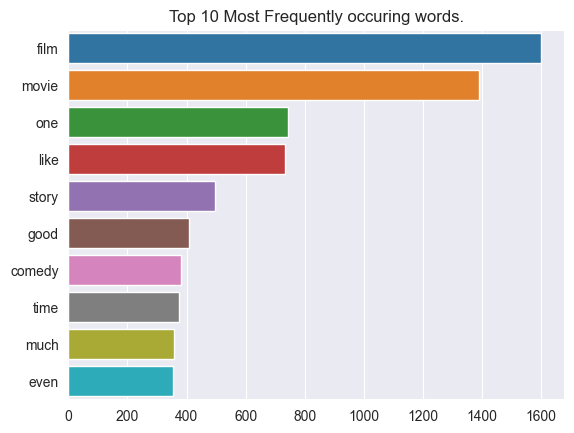

In [44]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently occuring words.')
plt.show()

In [45]:
term_freq_df['Label'].value_counts()

Label
pos    5331
neg    5331
Name: count, dtype: int64

In [46]:
good_reviews_corpus = []
bad_reviews_corpus = []
for i in trange(term_freq_df.shape[0], ncols=150, nrows=10, colour='orange', smoothing=0.8):
    if term_freq_df['Label'][i] == 'pos':
        good_reviews_corpus += term_freq_df['Review_lists'][i]
    else:
        bad_reviews_corpus += term_freq_df['Review_lists'][i]
print(len(good_reviews_corpus))
print(len(bad_reviews_corpus))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10662/10662 [00:00<00:00, 117601.02it/s]

57970
56859


In [47]:
good_most_common = Counter(good_reviews_corpus).most_common(10)
bad_most_common = Counter(bad_reviews_corpus).most_common(10)

In [48]:
gr_plot_data = pd.DataFrame([{'word':k, 'freq': v} for k,v in good_most_common])
br_plot_data = pd.DataFrame([{'word':k, 'freq': v} for k,v in bad_most_common])

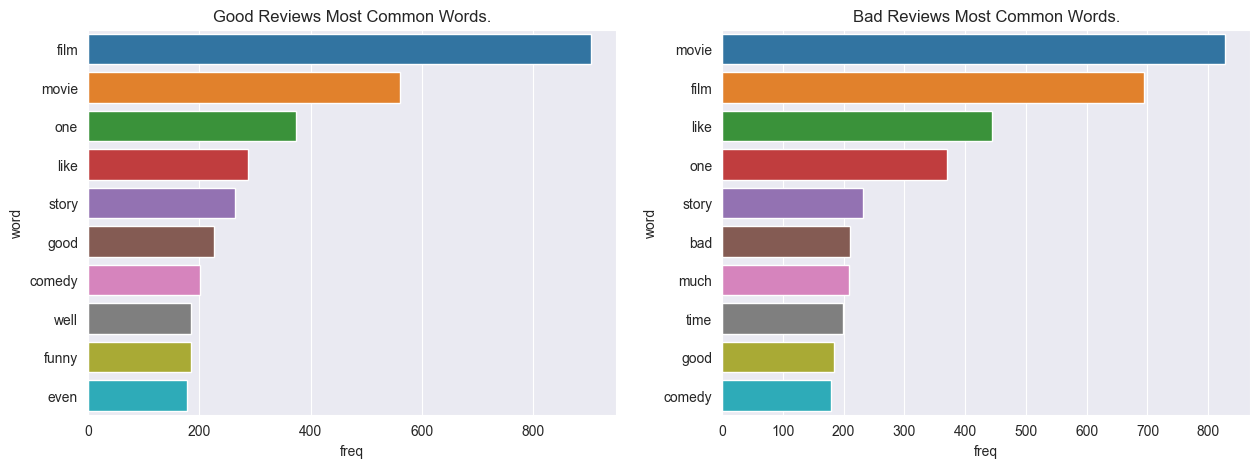

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

good_reviews_plot = sns.barplot(data=gr_plot_data, x='freq', y='word', ax=ax[0])
ax[0].set_title('Good Reviews Most Common Words.')

good_reviews_plot = sns.barplot(data=br_plot_data, x='freq', y='word', ax=ax[1])
ax[1].set_title('Bad Reviews Most Common Words.')

plt.show()

<hr style="border: 2px solid red; border-radius: 50%;">

## 4. Most Frequently Occuring N_grams.

N_grams help analyse phrases and not just words which can lead to better insights.

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 4.1: Bigrams

In [50]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(term_freq_df['Review'])

In [51]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
ngram_freq.columns = ['frequency', 'ngram']

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 4.2: Trigrams

In [52]:
cv = CountVectorizer(ngram_range=(3, 3))
trigrams = cv.fit_transform(term_freq_df['Review'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
ngram_freq.columns = ['frequency', 'ngram']

<hr style="border: 1px dotted purple; border-radius: 50%;">

### Implementing Helper function for creating N_grams.

In [53]:
def get_n_grams(dataset: pd.Series | typing.List[str], ngram_range: typing.Tuple[int, int]=(2, 2)) -> pd.DataFrame:
    cv = CountVectorizer(ngram_range=ngram_range)
    trigrams = cv.fit_transform(dataset)
    count_values = trigrams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
    ngram_freq.columns = ['frequency', 'ngram']
    return ngram_freq

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 4.3: Comaprison of Ngrams by Class / Category.

Plotting the Ngrams by Category of the Review. (positive or negative).

In [54]:
positive_reviews_bi_grams = get_n_grams(term_freq_df[term_freq_df['Label'] == 'pos']['Review'])
negative_reviews_bi_grams = get_n_grams(term_freq_df[term_freq_df['Label'] == 'neg']['Review'])

In [55]:
positive_reviews_tri_grams = get_n_grams(term_freq_df[term_freq_df['Label'] == 'pos']['Review'], (3, 3))
negative_reviews_tri_grams = get_n_grams(term_freq_df[term_freq_df['Label'] == 'neg']['Review'], (3, 3))

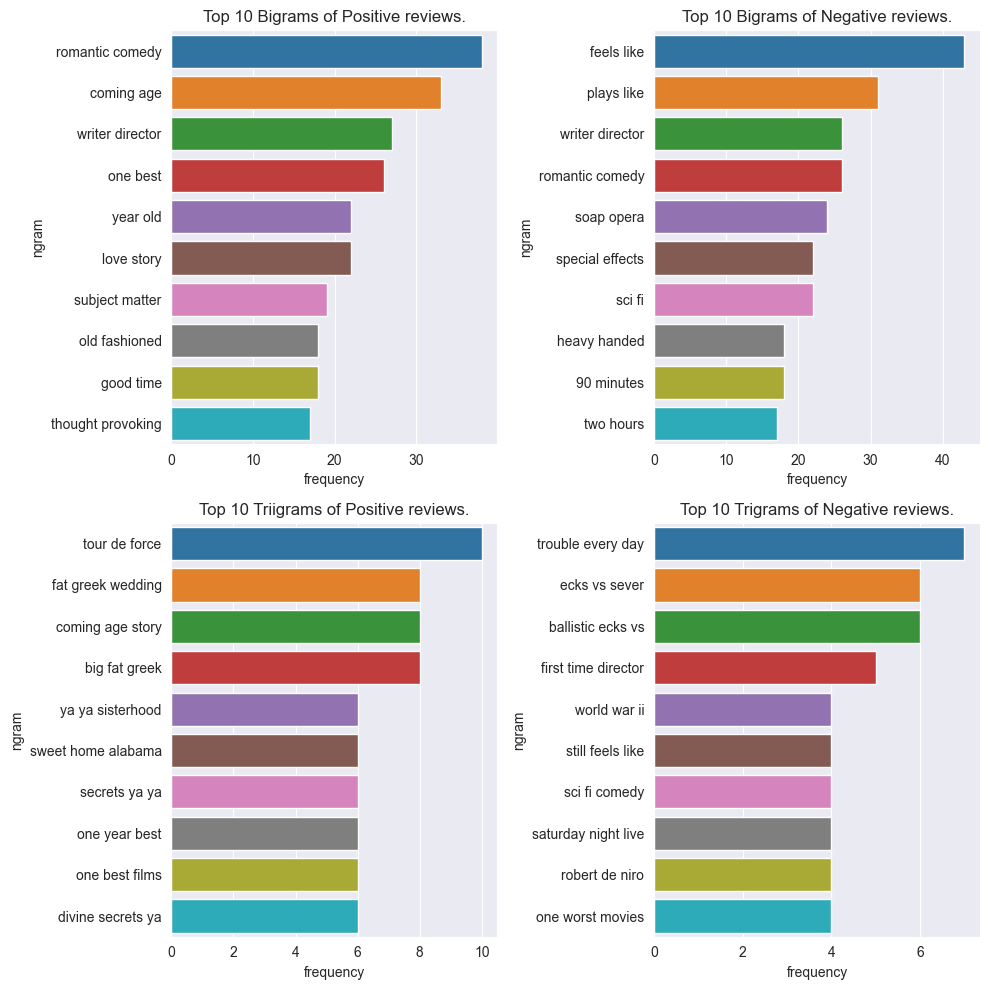

In [56]:
vfig, ax = plt.subplots(2, 2, figsize=(10, 10), layout='tight')
fig.suptitle("Ngrams of Reviews.", fontsize=18)

len_box_plot = sns.barplot(x=positive_reviews_bi_grams['frequency'][:10], y=positive_reviews_bi_grams['ngram'][:10],  ax=ax[0][0])
ax[0][0].set_title("Top 10 Bigrams of Positive reviews.")


len_line_plot = sns.barplot(x=negative_reviews_bi_grams['frequency'][:10], y=negative_reviews_bi_grams['ngram'][:10],  ax=ax[0][1])
ax[0][1].set_title("Top 10 Bigrams of Negative reviews.")

mean_word_count_box_plot = sns.barplot(x=positive_reviews_tri_grams['frequency'][:10], y=positive_reviews_tri_grams['ngram'][:10],  ax=ax[1][0])
ax[1][0].set_title("Top 10 Triigrams of Positive reviews.")


mean_word_count_line_plot = sns.barplot(x=negative_reviews_tri_grams['frequency'][:10], y=negative_reviews_tri_grams['ngram'][:10],  ax=ax[1][1])
ax[1][1].set_title("Top 10 Trigrams of Negative reviews.")

plt.show()

<hr style="border: 2px solid red; border-radius: 50%;">

## 5. Stemming

In [57]:
def stemming_process(text, stemmer=PorterStemmer()):
    """
    Args:
    ------
    text [type: List[str]]: The list objects whose stopwords will be removed.
    lemmatizer [type: class, default: WordNetLemmatizer()]: Type of lemmatizer to be applied.

    Returns:
    ------
    [type: List[str]]: list of lematized text.
    """
    return [stemmer.stem(c) for c in text.split()]

In [58]:
reviews_df['Review'] = [' '.join(stemming_process(review)) for review in reviews_df['Review']]

In [59]:
reviews_df['Review']

0        rock destin 21st centuri new conan go make spl...
1        gorgeous elabor continu lord ring trilog huge ...
2                                      effect tepid biopic
3         sometim like go movi fun wasabi good place start
4        emerg someth rare issu movi honest keenli obse...
                               ...                        
10657            terribl movi peopl nevertheless find move
10658          mani definit time waster movi must sure one
10659    stand crocodil hunter hurri badli cobbl look 1...
10660               thing look like made home video quicki
10661                          enigma well made dri placid
Name: Review, Length: 10662, dtype: object

<hr style="border: 2px solid red; border-radius: 50%;">

## 6. Lematizing

In [60]:
def lematizing_process(text, lemmatizer=WordNetLemmatizer()):
    """
    Args:
    ------
    text [type: List[str]]: The list objects whose stopwords will be removed.
    lemmatizer [type: class, default: WordNetLemmatizer()]: Type of lemmatizer to be applied.

    Returns:
    ------
    [type: List[str]]: list of lematized text.
    """
    return [lemmatizer.lemmatize(c) for c in text.split()]

In [61]:
reviews_df['Review'] = [' '.join(lematizing_process(review)) for review in reviews_df['Review']]

In [62]:
reviews_df['Review']

0        rock destin 21st centuri new conan go make spl...
1        gorgeous elabor continu lord ring trilog huge ...
2                                      effect tepid biopic
3         sometim like go movi fun wasabi good place start
4        emerg someth rare issu movi honest keenli obse...
                               ...                        
10657            terribl movi peopl nevertheless find move
10658          mani definit time waster movi must sure one
10659    stand crocodil hunter hurri badli cobbl look 1...
10660               thing look like made home video quicki
10661                          enigma well made dri placid
Name: Review, Length: 10662, dtype: object

<hr style="border: 2px solid red; border-radius: 50%;">

## 7. Applying TF-IDF

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 7.1: Preparing The Data.

<hr style="border: 1px dotted purple; border-radius: 50%;">

In [63]:
X = reviews_df['Review']
y = reviews_df['Label']

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.1.2: performing train-test-split of the reviews data.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.1.3: Encoding the Labels

- 'pos' = 1
- 'neg' = 0

In [65]:
label_encoder = LabelEncoder().fit(y)

In [66]:
y_train_encoded = label_encoder.fit_transform(y_train)

In [67]:
y_test_encoded = label_encoder.transform(y_test)

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 7.2: TfidfVectorizer

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.2.1: Initializing object 
The params are `use_idf=True`, `ngram_range=(1, 2)`, `max_features=500`.

In [132]:
tfid_vect = TfidfVectorizer(use_idf=True, ngram_range=(1, 2), max_features=500, min_df=2)

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.2.2: Fitting and Transforming Training Data.

In [69]:
X_train_vectors = tfid_vect.fit_transform(X_train)

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.2.3: Transforming Testing Data.

In [70]:
X_test_vectors = tfid_vect.transform(X_test)

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 7.2.4: Shape of both datasets.

In [71]:
print("X train tfid vectors: ", X_train_vectors.shape)
print("X test tfid vectors: ", X_test_vectors.shape)

X train tfid vectors:  (7463, 500)
X test tfid vectors:  (3199, 500)


<hr style="border: 2px solid red; border-radius: 50%;">

## 8: Supervised Machine Learning Models

Training Traditional Supervised Machine Learning Models for Sentimental CLassification.

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 8.1: Pipeline

Building a pipeline to automatically handle the process of NLP.

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 8.1.1: Class for Regex Transformation.

In [139]:
# Class for regex application
class ApplyRegex(BaseEstimator, TransformerMixin):

    def __init__(self, regex_transformers: dict[str, Callable[[str], str]]):
        self.regex_transformers = regex_transformers

    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)

        return X

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 8.1.2: Class for Stopwords removal from corpus.

In [73]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('english')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [74]:
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(review, self.text_stopwords)) for review in X]

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 8.1.3: Class for Stemming and Lemmatize Process.

In [75]:
class StemmingProcess(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer):
        self.stemmer = stemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stemming_process(review, self.stemmer)) for review in X]

<hr style="border: 1px dotted purple; border-radius: 50%;">

#### 8.1.4: Class for Stemming and Lemmatize Process.

In [76]:
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer: TfidfVectorizer()):
        self.vectorizer = vectorizer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 8.2: Building the Pipeline

<hr style="border: 1px dotted purple; border-radius: 50%;">

Defining regex_transformers.

In [137]:
regex_transformers = {
    'break_line': re_breakline,
    'hyperlinks': re_hyperlinks,
    'negations': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

<hr style="border: 1px dotted purple; border-radius: 50%;">

Defining Vectorizer to extract Features from text

In [78]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1, 2), max_features=500)

Building the Pipeline.

In [133]:
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('stemming', StemmingProcess(PorterStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer)),
])

In [140]:
text_pipeline.fit(reviews_df['Review'])

NameError: name 'regex_function' is not defined

<hr style="border: 1px solid yellow; border-radius: 50%;">

### 8.3: Logistic Regression

<hr style="border: 1px dotted purple; border-radius: 50%;">

In [124]:
log_reg_model = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

In [125]:
log_reg_tfidf = log_reg_model.fit(X_train_vectors, y_train_encoded)

In [126]:
print(log_reg_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


<hr style="border: 1px dotted purple; border-radius: 50%;">

### 8.3.2: Performance of Logistic Regression Model on test dataset.

In [127]:
y_pred = log_reg_model.predict(X_test_vectors)
print(y_pred)

[1 1 0 ... 1 0 1]


In [129]:
accuracy_score(y_test_encoded, y_pred)

0.6917786808377618